In [42]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use("seaborn")

# Fetch and setup the dataset 

In [2]:
molecules = np.load("../butadien/data/400/molecules400.npy")
S = np.load("../butadien/data/400/S400.npy")
P = np.load("../butadien/data/400/P400.npy")

dim = 26
species = "C"
testing_samples

In [3]:
from SCFInitialGuess.utilities.dataset import DescribedMoleculesDataset
from SCFInitialGuess.descriptors.utilities import BlockExtractor
from SCFInitialGuess.descriptors.coordinate_descriptors import NonWeighted


class SCFRunResult(object):
    """Class that holds all data created in an scf calculation. 
    Kind of linke the Molecule class with the Matrices."""

    def __init__(self, molecule, S=None, P=None, F=None, H=None):
        self.molecule = molecule
        self.S = S
        self.P = P
        self.F = F
        self.H = H
        
    @property
    def species(self):
        return self.molecule.species
        
        
class AtomicDensityBlockExtractor(BlockExtractor):
    def __init__(self, target_species, basis):
        self.target_species = target_species
        self.basis = basis
    
    def calculate_descriptors(self, scf_result):
        return self.extract_blocks(scf_result.P.reshape(dim, dim), scf_result.species)
    
class GaussianDescriptorWrapper(NonWeighted):
    def __init__(self, target_species, *args, **kwargs):
        """Args: radial, azimuthal and polar descriptors"""
        
        self.target_species = target_species
        
        super(GaussianDescriptorWrapper, self).__init__(*args, **kwargs)
    
    def atoms_of_interest(self, atoms_in_molecule):
        return [i for i in range(len(atoms_in_molecule)) if atoms_in_molecule[i] == self.target_species]
        
    def calculate_descriptors(self, scf_result):
        
        indices_of_interest = self.atoms_of_interest(scf_result.species)
        
        descriptors = []
        
        for index in indices_of_interest:
            descriptors.append(self.calculate_atom_descriptor(
                index, scf_result.molecule, self.number_of_descriptors
            ))
            
        return descriptors
    

In [4]:
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    Gaussians, RADIAL_GAUSSIAN_MODELS, AZIMUTHAL_GAUSSIAN_MODELS, POLAR_GAUSSIAN_MODELS

input_descriptor_C =  GaussianDescriptorWrapper(
    species,
    Gaussians(*RADIAL_GAUSSIAN_MODELS["Equidistant-Broadening_1"]),
    Gaussians(*AZIMUTHAL_GAUSSIAN_MODELS["Equisitant_1"]),
    Gaussians(*POLAR_GAUSSIAN_MODELS["Equisitant_1"])
)
output_descriptor = AtomicDensityBlockExtractor(species, "sto-3g")

In [5]:
from SCFInitialGuess.utilities.dataset import DescribedMoleculesDataset

dataset = DescribedMoleculesDataset(
    [SCFRunResult(molecule, S=s, P=p) for molecule, s, p in zip(molecules, S, P)],
    input_descriptor_C,
    output_descriptor,
    split_test=testing_samples
)
dataset.make_normalization()

# Train a network 

In [6]:
from SCFInitialGuess.nn.training import Trainer
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.cost_functions import RegularizedMSE

structure = [18, 50, 40, 25, 10, 15]

trainer = Trainer(
    EluTrNNN(structure),
    cost_function=RegularizedMSE(alpha=1e-7),
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3)
)

trainer.setup()

network, sess = trainer.train(
    dataset,
    convergence_threshold=5e-4
)
    

[-] 2018-06-25 11:43:14: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-06-25 11:43:14: Setting up the training in the target graph ...
[-] 2018-06-25 11:43:14: network ...
[-] 2018-06-25 11:43:15: error function ...
[-] 2018-06-25 11:43:15: cost function ...
[-] 2018-06-25 11:43:15: training step
[-] 2018-06-25 11:43:16: Starting network training ...
[ ] 2018-06-25 11:43:17: Val. Cost: 4.207E-01. Error: 4.207E-01. Diff: 1.0E+10
[ ] 2018-06-25 11:43:19: Val. Cost: 3.410E-03. Error: 3.409E-03. Diff: 4.2E-01
[-] 2018-06-25 11:43:21: Convergence reached after 400 steps.
[-] 2018-06-25 11:43:23: Test error: 3.43614E-03


# For H 

In [7]:
species = "H"

input_descriptor_H =  GaussianDescriptorWrapper(
    species,
    Gaussians(*RADIAL_GAUSSIAN_MODELS["Equidistant-Broadening_1"]),
    Gaussians(*AZIMUTHAL_GAUSSIAN_MODELS["Equisitant_1"]),
    Gaussians(*POLAR_GAUSSIAN_MODELS["Equisitant_1"])
)
output_descriptor = AtomicDensityBlockExtractor(species, "sto-3g")
dataset_H = DescribedMoleculesDataset(
    [SCFRunResult(molecule, S=s, P=p) for molecule, s, p in zip(molecules, S, P)],
    input_descriptor_H,
    output_descriptor,
    split_test=testing_samples
)
dataset_H.make_normalization()

In [8]:
dataset_H.testing[1][0].shape

(1,)

In [9]:
from SCFInitialGuess.nn.training import Trainer
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.cost_functions import RegularizedMSE

structure = [18, 50, 40, 25, 10, 1]

trainer_H = Trainer(
    EluTrNNN(structure),
    cost_function=RegularizedMSE(alpha=1e-7),
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3)
)

trainer_H.setup()

network_H, sess_H = trainer_H.train(
    dataset_H,
    convergence_threshold=5e-4
)

[-] 2018-06-25 11:43:32: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-06-25 11:43:32: Setting up the training in the target graph ...
[-] 2018-06-25 11:43:32: network ...
[-] 2018-06-25 11:43:32: error function ...
[-] 2018-06-25 11:43:32: cost function ...
[-] 2018-06-25 11:43:32: training step
[-] 2018-06-25 11:43:32: Starting network training ...
[ ] 2018-06-25 11:43:35: Val. Cost: 3.636E-01. Error: 3.636E-01. Diff: 1.0E+10
[ ] 2018-06-25 11:43:38: Val. Cost: 1.391E-03. Error: 1.390E-03. Diff: 3.6E-01
[-] 2018-06-25 11:43:41: Convergence reached after 400 steps.
[-] 2018-06-25 11:43:43: Test error: 1.06948E-03


# Testing: do superposition

In [48]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def sannd_guess(molecule):
    
    old_guess = None
    guess = np.array([])
    
    for index, atom in enumerate(molecule.species):
        if atom == "C":
            input_values = input_descriptor_C.calculate_atom_descriptor(
                index, molecule , input_descriptor_C.number_of_descriptors
            ).reshape(-1, 18)
            block_triu = network.run(sess, input_values)
            block = reconstruct_from_triu(block_triu, 5)
        elif atom == "H":
            input_values = input_descriptor_H.calculate_atom_descriptor(
                index, molecule , input_descriptor_H.number_of_descriptors
            ).reshape(-1, 18)
            block_triu = network_H.run(sess_H, input_values)
            block = reconstruct_from_triu(block_triu, 1)
        
        if len(guess) == 0:
            guess = block
        else:    
            old_guess = guess
            new_dim = len(guess) + len(block)
            guess = np.zeros((new_dim, new_dim))
            guess[:len(old_guess), :len(old_guess)] = old_guess
            guess[len(old_guess):, len(old_guess):] = block
        
    return guess

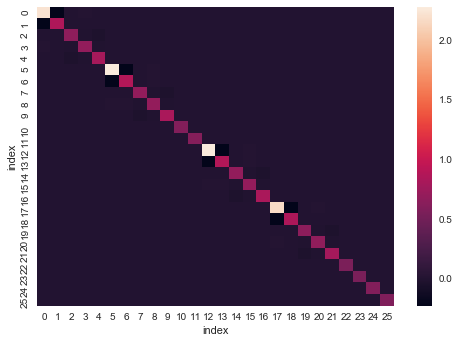

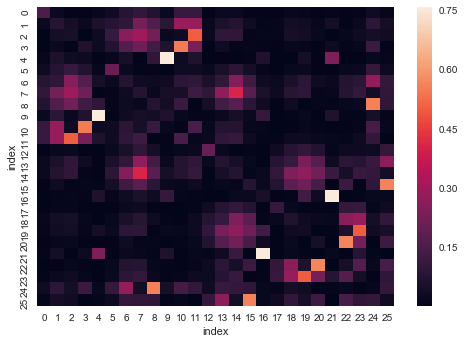

In [52]:
from SCFInitialGuess.utilities.analysis import matrix_error
plt.figure()
matrix_error(sannd_guess(dataset._testing[0].molecule))
plt.show()

plt.figure()
matrix_error(np.abs(sannd_guess(dataset._testing[0].molecule) -dataset._testing[0].P.reshape(dim, dim)))
plt.show()


## Batch calculation

In [55]:
def sannd_batch(molecules):
    guesses = []
    for molecule in molecules:
        guesses.append(sannd_guess(molecule))  
    return np.array(guesses)

In [60]:
molecules_dataset = [x.molecule for x in dataset._testing ]
p_sannd = sannd_batch(molecules_dataset)

# Analysis 

### Absolute error 

In [62]:
from SCFInitialGuess.utilities.analysis import measure_absolute_error, statistics

p_dataset = [x.P.reshape(dim, dim) for x in dataset._testing]

statistics(measure_absolute_error(p_sannd, p_dataset))

(0.07589268469094461, 0.020068945599750757)

### HF Energy error

In [66]:
from SCFInitialGuess.utilities.analysis import measure_hf_energy_error

statistics(list(measure_hf_energy_error(p_sannd, p_dataset, molecules_dataset)))

(2.459753371585217, 0.22551012660799358)

### Iterations

In [68]:
from SCFInitialGuess.utilities.analysis import measure_iterations, mf_initializer
statistics(measure_iterations(mf_initializer, p_sannd.astype("float64"), molecules_dataset))

[ ] 2018-06-25 12:16:30: Iteration calculation: 0
[ ] 2018-06-25 12:16:30: Iteration calculation: 1
[ ] 2018-06-25 12:16:31: Iteration calculation: 2
[ ] 2018-06-25 12:16:31: Iteration calculation: 3
[ ] 2018-06-25 12:16:31: Iteration calculation: 4
[ ] 2018-06-25 12:16:32: Iteration calculation: 5
[ ] 2018-06-25 12:16:32: Iteration calculation: 6
[ ] 2018-06-25 12:16:33: Iteration calculation: 7
[ ] 2018-06-25 12:16:33: Iteration calculation: 8
[ ] 2018-06-25 12:16:33: Iteration calculation: 9
[ ] 2018-06-25 12:16:34: Iteration calculation: 10
[ ] 2018-06-25 12:16:34: Iteration calculation: 11
[ ] 2018-06-25 12:16:34: Iteration calculation: 12
[ ] 2018-06-25 12:16:35: Iteration calculation: 13
[ ] 2018-06-25 12:16:35: Iteration calculation: 14
[ ] 2018-06-25 12:16:36: Iteration calculation: 15
[ ] 2018-06-25 12:16:36: Iteration calculation: 16
[ ] 2018-06-25 12:16:36: Iteration calculation: 17
[ ] 2018-06-25 12:16:37: Iteration calculation: 18
[ ] 2018-06-25 12:16:37: Iteration calcul

[ ] 2018-06-25 12:17:35: Iteration calculation: 160
[ ] 2018-06-25 12:17:35: Iteration calculation: 161
[ ] 2018-06-25 12:17:36: Iteration calculation: 162
[ ] 2018-06-25 12:17:36: Iteration calculation: 163
[ ] 2018-06-25 12:17:37: Iteration calculation: 164
[ ] 2018-06-25 12:17:37: Iteration calculation: 165
[ ] 2018-06-25 12:17:38: Iteration calculation: 166
[ ] 2018-06-25 12:17:38: Iteration calculation: 167
[ ] 2018-06-25 12:17:39: Iteration calculation: 168
[ ] 2018-06-25 12:17:39: Iteration calculation: 169
[ ] 2018-06-25 12:17:40: Iteration calculation: 170
[ ] 2018-06-25 12:17:40: Iteration calculation: 171
[ ] 2018-06-25 12:17:41: Iteration calculation: 172
[ ] 2018-06-25 12:17:41: Iteration calculation: 173
[ ] 2018-06-25 12:17:42: Iteration calculation: 174
[ ] 2018-06-25 12:17:42: Iteration calculation: 175
[ ] 2018-06-25 12:17:43: Iteration calculation: 176
[ ] 2018-06-25 12:17:43: Iteration calculation: 177
[ ] 2018-06-25 12:17:44: Iteration calculation: 178
[ ] 2018-06-

(17.97222222222222, 1.730223349601482)